### Purpose

This notebook is meant to be a space to load the model trained elsewhere and evaluate it's performance / plot predictions / etc.

In [1]:
# Specify that this notebook should only use the CPU
# This avoids memory problems if the model is running on the GPU elsewhere
# Note: do not try to train / predict as this will likely be very slow
import os
os.environ["THEANO_FLAGS"] = "device=cpu"

In [2]:
# Do I need anything from keras beyond load_model?

import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, merge, Activation, Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Cropping2D, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras import backend as K
from keras.regularizers import l2
from keras.constraints import maxnorm
from keras.layers.advanced_activations import LeakyReLU
K.set_image_dim_ordering('th')  # Theano dimension ordering in this code
# "tf" assumes (rows, cols, channels) while "th" assumes (channels, rows, cols)
# Possibly change this around natively in the data so the backend doesn't have to switch them
# Only necessary if I use TF!

from matplotlib import pyplot as plt
from pushbullet import Pushbullet

Using Theano backend.


In [4]:
# Pushbullet notifier
def push(title='Done!',text=''):
    Pushbullet('o.YFPNNPfGRekivaCGHa4qMSgjZt8zJ6FL').devices[0].push_note(title,text)
    
# Import the training data
def import_data(img_h,img_w):
    x = np.load('./data/training-data/train_imgs_{}x{}_augmented_array.npy'.format(img_h,img_w),'r')
    y = np.load('./data/training-data/train_msks_{}x{}_augmented_array.npy'.format(img_h,img_w),'r')
    '''
    Classes:
    0 Buildings - large building, residential, non-residential, fuel storage facility, fortified building
    1 Misc. Manmade structures 
    2 Road 
    3 Track - poor/dirt/cart track, footpath/trail
    4 Trees - woodland, hedgerows, groups of trees, standalone trees
    5 Crops - contour ploughing/cropland, grain (wheat) crops, row (potatoes, turnips) crops
    6 Waterway 
    7 Standing water
    8 Vehicle Large - large vehicle (e.g. lorry, truck,bus), logistics vehicle
    9 Vehicle Small - small vehicle (car, van), motorbike
    '''    
    return x, y

img_h,img_w = 160,160
x, y = import_data(img_h,img_w)
run = np.load('./data/misc/run_counter.npy')
print('This is run # %i' %run)

This is run # 98


In [5]:
%%time
def compiler(img_rows = x.shape[2],img_cols = x.shape[3],
            nfilters = 64,activation = 'relu',init = 'he_normal',
            lr=1.0,decay=0.0,momentum=0.0, nesterov=False,reg=0.01,p=[0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2]):
    
    def jaccard(y_true, y_pred,smooth=1.):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    
    def jaccard_0(y_true, y_pred,smooth=1.):
        y_true_f = K.flatten(y_true[0])
        y_pred_f = K.flatten(y_pred[0])
        intersection = K.sum(y_true_f * y_pred_f)
        return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    
    def jaccard_1(y_true, y_pred,smooth=1.):
        y_true_f = K.flatten(y_true[1])
        y_pred_f = K.flatten(y_pred[1])
        intersection = K.sum(y_true_f * y_pred_f)
        return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    
    def jaccard_2(y_true, y_pred,smooth=1.):
        y_true_f = K.flatten(y_true[2])
        y_pred_f = K.flatten(y_pred[2])
        intersection = K.sum(y_true_f * y_pred_f)
        return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    
    def jaccard_3(y_true, y_pred,smooth=1.):
        y_true_f = K.flatten(y_true[3])
        y_pred_f = K.flatten(y_pred[3])
        intersection = K.sum(y_true_f * y_pred_f)
        return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    
    def jaccard_4(y_true, y_pred,smooth=1.):
        y_true_f = K.flatten(y_true[4])
        y_pred_f = K.flatten(y_pred[4])
        intersection = K.sum(y_true_f * y_pred_f)
        return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    
    def jaccard_5(y_true, y_pred,smooth=1.):
        y_true_f = K.flatten(y_true[5])
        y_pred_f = K.flatten(y_pred[5])
        intersection = K.sum(y_true_f * y_pred_f)
        return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    
    def jaccard_6(y_true, y_pred,smooth=1.):
        y_true_f = K.flatten(y_true[6])
        y_pred_f = K.flatten(y_pred[6])
        intersection = K.sum(y_true_f * y_pred_f)
        return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    
    def jaccard_7(y_true, y_pred,smooth=1.):
        y_true_f = K.flatten(y_true[7])
        y_pred_f = K.flatten(y_pred[7])
        intersection = K.sum(y_true_f * y_pred_f)
        return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    
    def jaccard_8(y_true, y_pred,smooth=1.):
        y_true_f = K.flatten(y_true[8])
        y_pred_f = K.flatten(y_pred[8])
        intersection = K.sum(y_true_f * y_pred_f)
        return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    
    def jaccard_9(y_true, y_pred,smooth=1.):
        y_true_f = K.flatten(y_true[9])
        y_pred_f = K.flatten(y_pred[9])
        intersection = K.sum(y_true_f * y_pred_f)
        return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    
    def Conv2DReluBatchNorm(n_filter, w_filter, h_filter, inputs, activation, init='he_uniform',dropout=0.2):
        # Batch norm after activation / leakyrelu
        #return BatchNormalization(mode=2, axis=1)(LeakyReLU()((Convolution2D(n_filter, w_filter, h_filter, border_mode='same',init=init,W_regularizer=l2(reg),W_constraint = maxnorm(3))(inputs))))
        
        # Batch norm before activation
        #return LeakyReLU()(BatchNormalization(mode=0, axis=1)((Convolution2D(n_filter, w_filter, h_filter, border_mode='same',init=init,W_regularizer=l2(reg),W_constraint = maxnorm(3))(inputs))))
        
        # Batch norm after activation / relu
        return BatchNormalization(mode=2, axis=1)(Activation(activation=activation)((Convolution2D(n_filter, w_filter, h_filter, border_mode='same',init=init,W_regularizer=l2(reg),W_constraint = maxnorm(3))(inputs))))
        
    def up_conv(nfilters,filter_factor,inputs,init=init,activation=activation):
        # No batch norm
        #return LeakyReLU()(Convolution2D(nfilters*filter_factor, 2, 2, border_mode='same',init=init,W_regularizer=l2(reg),W_constraint = maxnorm(3))(UpSampling2D(size=(2, 2))(inputs)))
        
        # Batch norm after activation
        #return BatchNormalization(mode=2, axis=1)(LeakyReLU()(Convolution2D(nfilters*filter_factor, 2, 2, border_mode='same',init=init,W_regularizer=l2(reg),W_constraint = maxnorm(3))(UpSampling2D(size=(2, 2))(inputs))))
        
        # Batch norm after activation / relu
        return BatchNormalization(mode=2, axis=1)(Activation(activation=activation)(Convolution2D(nfilters*filter_factor, 2, 2, border_mode='same',init=init,W_regularizer=l2(reg),W_constraint = maxnorm(3))(UpSampling2D(size=(2, 2))(inputs))))

    inputs = Input((20, img_rows, img_cols))
    #padded = ZeroPadding2D(padding=(12,12))(inputs)
    
    conv1 = Conv2DReluBatchNorm(nfilters, 3, 3, inputs, activation=activation,init=init)
    conv1 = Conv2DReluBatchNorm(nfilters, 3, 3, conv1, activation=activation,init=init)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(p=p[0])(pool1)

    conv2 = Conv2DReluBatchNorm(nfilters*2, 3, 3, pool1, activation=activation,init=init)
    conv2 = Conv2DReluBatchNorm(nfilters*2, 3, 3, conv2, activation=activation,init=init)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(p=p[1])(pool2)

    conv3 = Conv2DReluBatchNorm(nfilters*4, 3, 3, pool2, activation=activation,init=init)
    conv3 = Conv2DReluBatchNorm(nfilters*4, 3, 3, conv3, activation=activation,init=init)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(p=p[2])(pool3)

    conv4 = Conv2DReluBatchNorm(nfilters*8, 3, 3, pool3, activation=activation,init=init)
    conv4 = Conv2DReluBatchNorm(nfilters*8, 3, 3, conv4, activation=activation,init=init)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(p=p[3])(pool4)

    conv5 = Conv2DReluBatchNorm(nfilters*16, 3, 3, pool4, activation=activation,init=init)
    conv5 = Conv2DReluBatchNorm(nfilters*16, 3, 3, conv5, activation=activation,init=init)
    conv5 = Dropout(p=p[4])(conv5)
        
    up6 = merge([up_conv(nfilters,8,conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Conv2DReluBatchNorm(nfilters*8, 3, 3, up6, activation=activation,init=init)
    conv6 = Conv2DReluBatchNorm(nfilters*8, 3, 3, conv6, activation=activation,init=init)
    conv6 = Dropout(p=p[5])(conv6)

    up7 = merge([up_conv(nfilters,4,conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Conv2DReluBatchNorm(nfilters*4, 3, 3, up7, activation=activation,init=init)
    conv7 = Conv2DReluBatchNorm(nfilters*4, 3, 3, conv7, activation=activation,init=init)
    conv7 = Dropout(p=p[6])(conv7)

    up8 = merge([up_conv(nfilters,2,conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Conv2DReluBatchNorm(nfilters*2, 3, 3, up8, activation=activation,init=init)
    conv8 = Conv2DReluBatchNorm(nfilters*2, 3, 3, conv8, activation=activation,init=init)
    conv8 = Dropout(p=p[7])(conv8)

    up9 = merge([up_conv(nfilters,1,conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Conv2DReluBatchNorm(nfilters, 3, 3, up9, activation=activation,init=init)
    conv9 = Conv2DReluBatchNorm(nfilters, 3, 3, conv9, activation=activation,init=init)
    conv9 = Dropout(p=p[8])(conv9)
    
    conv10 = Conv2DReluBatchNorm(10, 1, 1, conv9, activation='relu',init=init)
    #cropped = Cropping2D(cropping=((12,12), (12,12)))(conv10)
    output = Activation(activation='sigmoid')(conv10)
    
    model = Model(input=inputs, output=output)
    
    model.compile(optimizer=Adam(lr=lr,decay=decay), loss='binary_crossentropy',
                  metrics=[jaccard,jaccard_0,jaccard_1,jaccard_2,jaccard_3,
                           jaccard_4,jaccard_5,jaccard_6,jaccard_7,jaccard_8,jaccard_9])
    
    return model

p = [0]*9
# p=[0.1,0.2,0.3,0.4,0.5,0.4,0.3,0.2,0.1] # current version
#p=[0.2,0.3,0.4,0.5,0.5,0.5,0.4,0.3,0.2] # symmetric but more dropout
#p=[0.2,0.2,0.3,0.3,0.4,0.4,0.5,0.5,0.6] # increasing

model = compiler(img_rows=x.shape[2],img_cols=x.shape[3],
            nfilters=64,activation='relu',init='he_normal',
            lr=0.001,decay=0,momentum=0,reg=0,p=p)

CPU times: user 2.69 s, sys: 168 ms, total: 2.86 s
Wall time: 3.46 s


In [40]:
model.load_weights('./data/weights/model_weights_all-classes_run_{}.h5'.format(run))

In [4]:
def plot_all(i,classType):
    fig = plt.figure(figsize=(6,6))

    ax1 = fig.add_subplot(221)
    ax1.imshow(preds[i,0,...],cmap='spectral')

    ax2 = fig.add_subplot(222)
    ax2.imshow(np.rint(preds[i,0,...]),cmap='spectral')

    ax3 = fig.add_subplot(223)
    ax3.imshow(x[i,17,...],cmap='Greys')

    ax4 = fig.add_subplot(224)
    ax4.imshow(y_oneclass[i,classType,:,:],cmap='spectral')
    
    plt.show()

In [ ]:
def plot_everything(n_classes,n_images,random=True):
    fig = plt.figure(figsize=(12,36))
    if random:
        num = np.random.randint(10,25,n_images)
    else:
        num = np.arange(0,10)
    for i in range(1,10):
        ax1 = fig.add_subplot(10,8,8*i-7)
        ax1.imshow(preds[num[i],0,...],cmap='spectral')
        
        ax2 = fig.add_subplot(10,8,8*i-6)
        ax2.imshow(y_oneclass[num[i],0,...],cmap='spectral')
        
        ax3 = fig.add_subplot(10,8,8*i-5)
        ax3.imshow(preds[num[i],1,...],cmap='spectral')
        
        ax4 = fig.add_subplot(10,8,8*i-4)
        ax4.imshow(y_oneclass[num[i],1,...],cmap='spectral')
        
        ax5 = fig.add_subplot(10,8,8*i-3)
        ax5.imshow(preds[num[i],2,...],cmap='spectral')
        
        ax6 = fig.add_subplot(10,8,8*i-2)
        ax6.imshow(y_oneclass[num[i],2,...],cmap='spectral')
        
        ax7 = fig.add_subplot(10,8,8*i-1)
        ax7.imshow(preds[num[i],3,...],cmap='spectral')
        
        ax8 = fig.add_subplot(10,8,8*i)
        ax8.imshow(y_oneclass[num[i],3,...],cmap='spectral')
        
    plt.show()

In [6]:
def jaccard(y_true, y_pred,smooth=1.):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
model = load_model('u-net-complete-model-run_88-class_2.h5',custom_objects={'jaccard': jaccard})

This is image #330


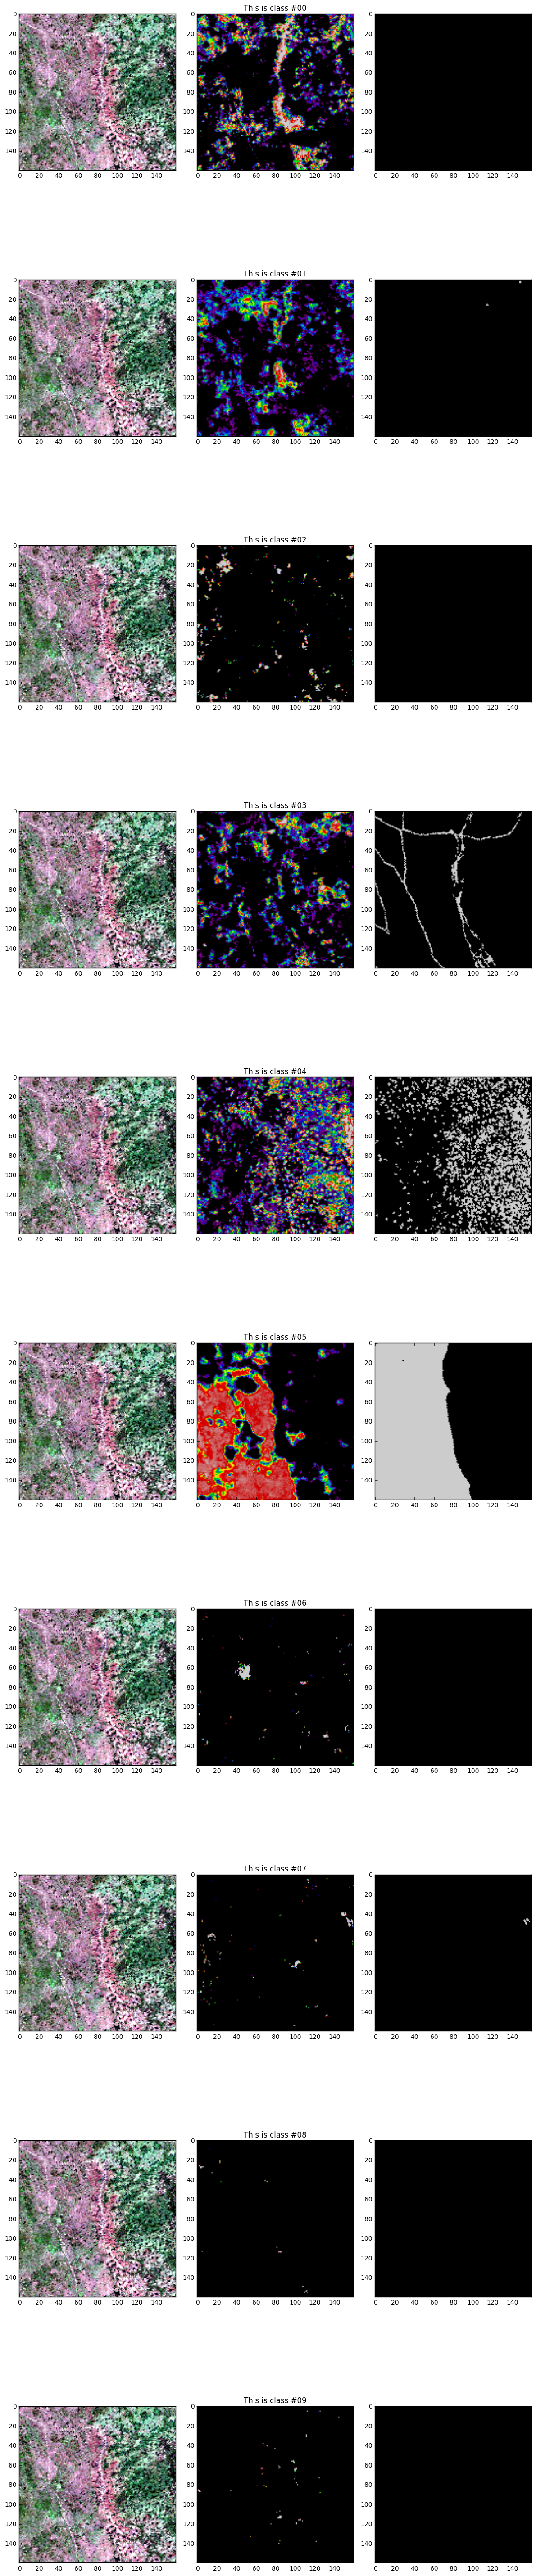

In [42]:
def plot_pred():
    fig = plt.figure(figsize=(12,60))
    i = np.random.choice(x.shape[0])
    print('This is image #{:03d}'.format(i))
    for class_ in range(10):
        ax = fig.add_subplot(10,3,3*(class_+1)-2)
        ax.imshow(np.rollaxis(x[i,:3,...],0,3))

        # Predicted features
        ax = fig.add_subplot(10,3,3*(class_+1)-1)
        ax.imshow(model.predict(x[i:i+1])[0,class_,...],cmap='spectral')
        ax.set_title('This is class #{:02d}'.format(class_))

        # Actual features
        ax = fig.add_subplot(10,3,3*(class_+1))
        ax.imshow(y[i,class_,...],cmap='spectral')
    
    plt.tight_layout()
    plt.show()
    
plot_pred()

In [ ]:
model.evaluate(x,y_oneclass)

In [13]:
0.2*400

80.0

389


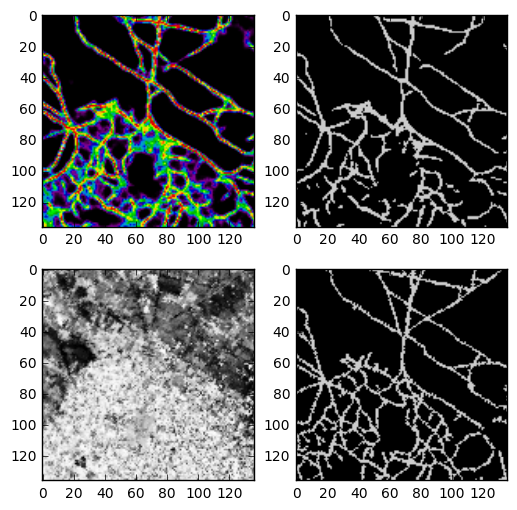

In [27]:
norm = False
if norm:
    preds = norm_preds(preds)
i = np.random.choice(range(320,400),1)[0]
print(i)
plot_all(i,0)